Data shape: (1326, 6)
Date range: 2020-10-12 00:00:00 ~ 2026-01-12 00:00:00


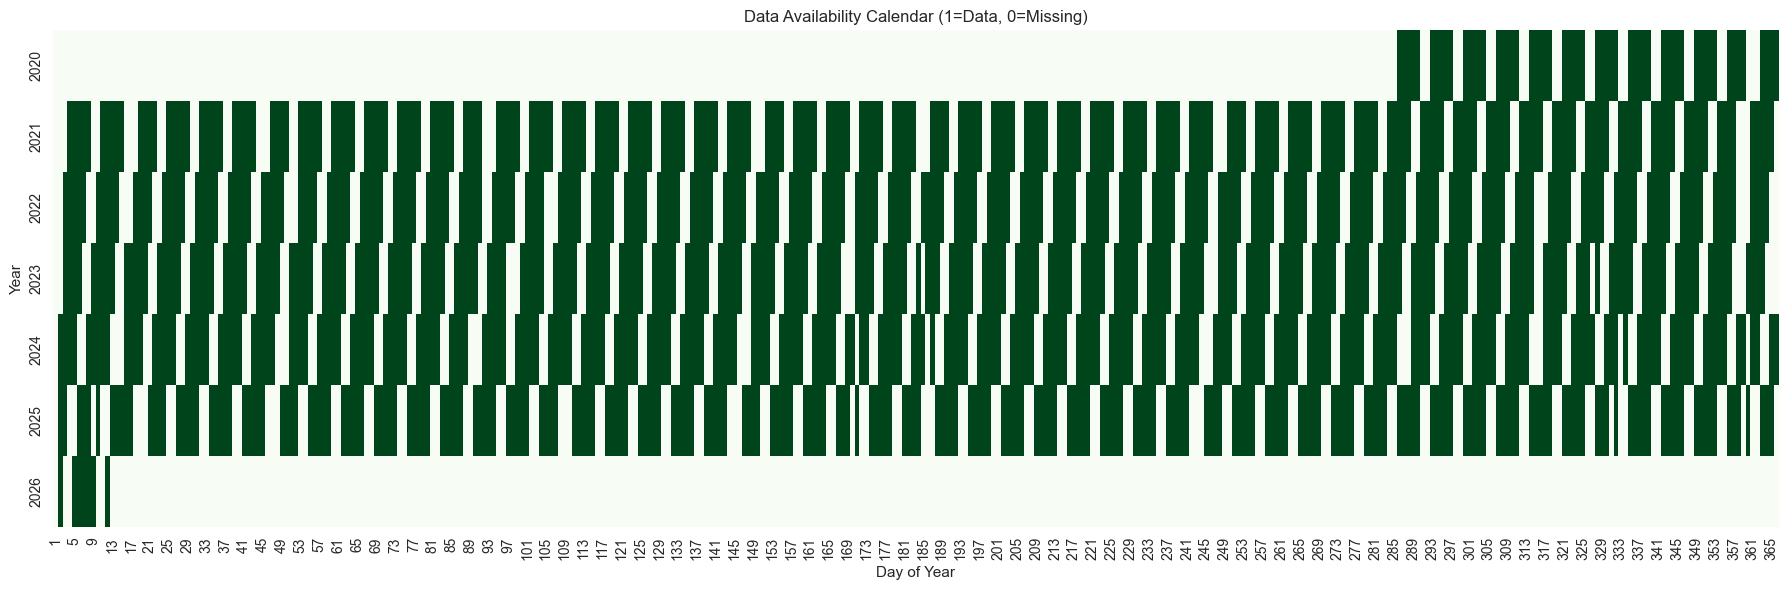

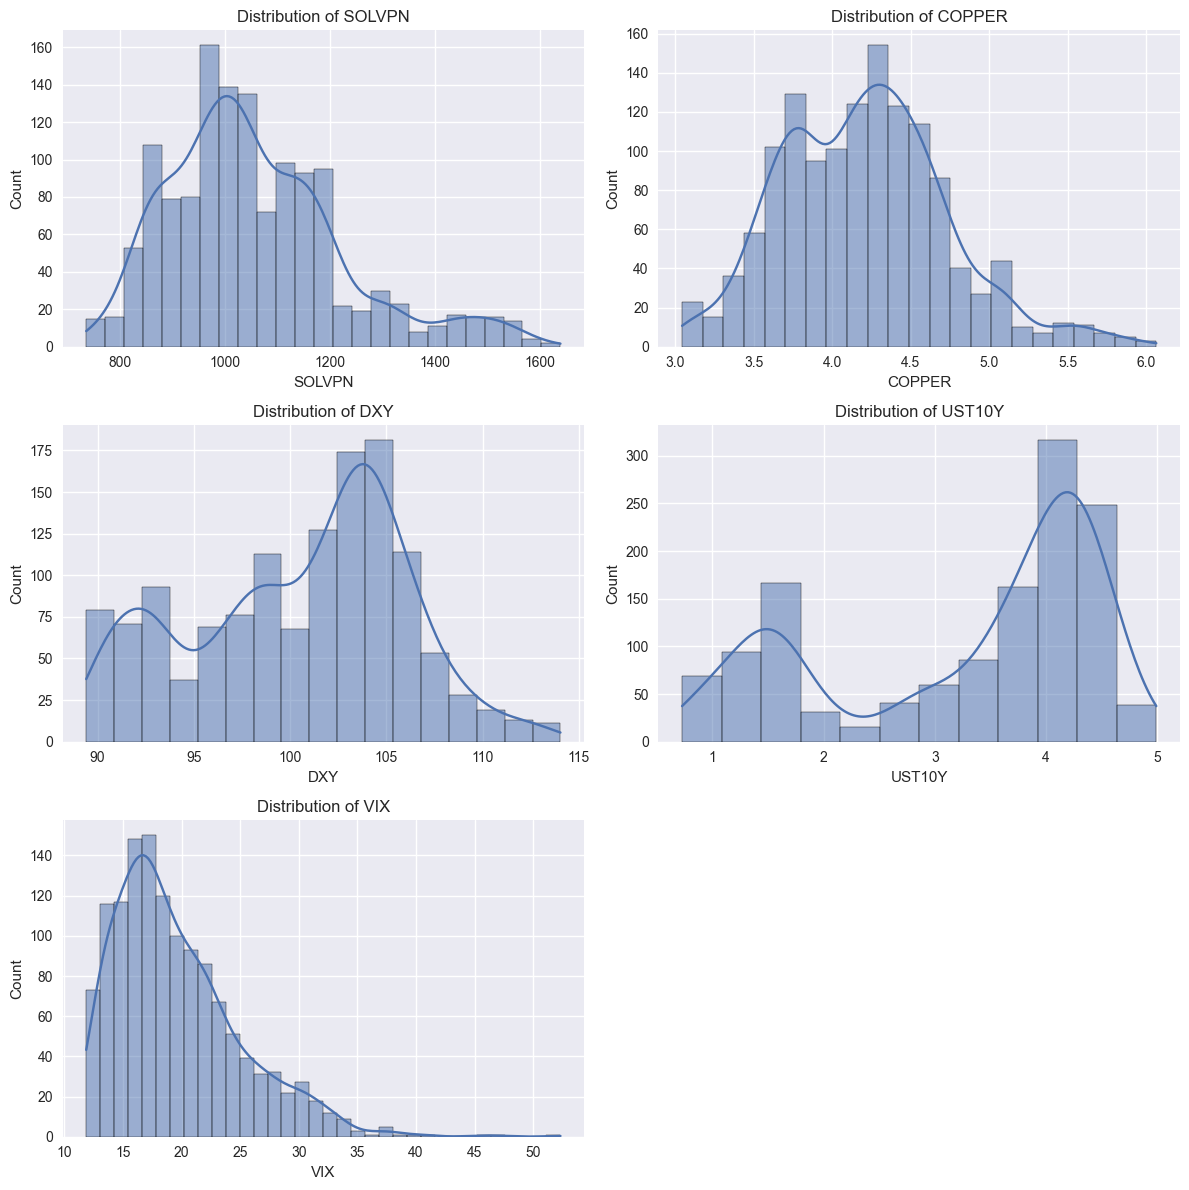

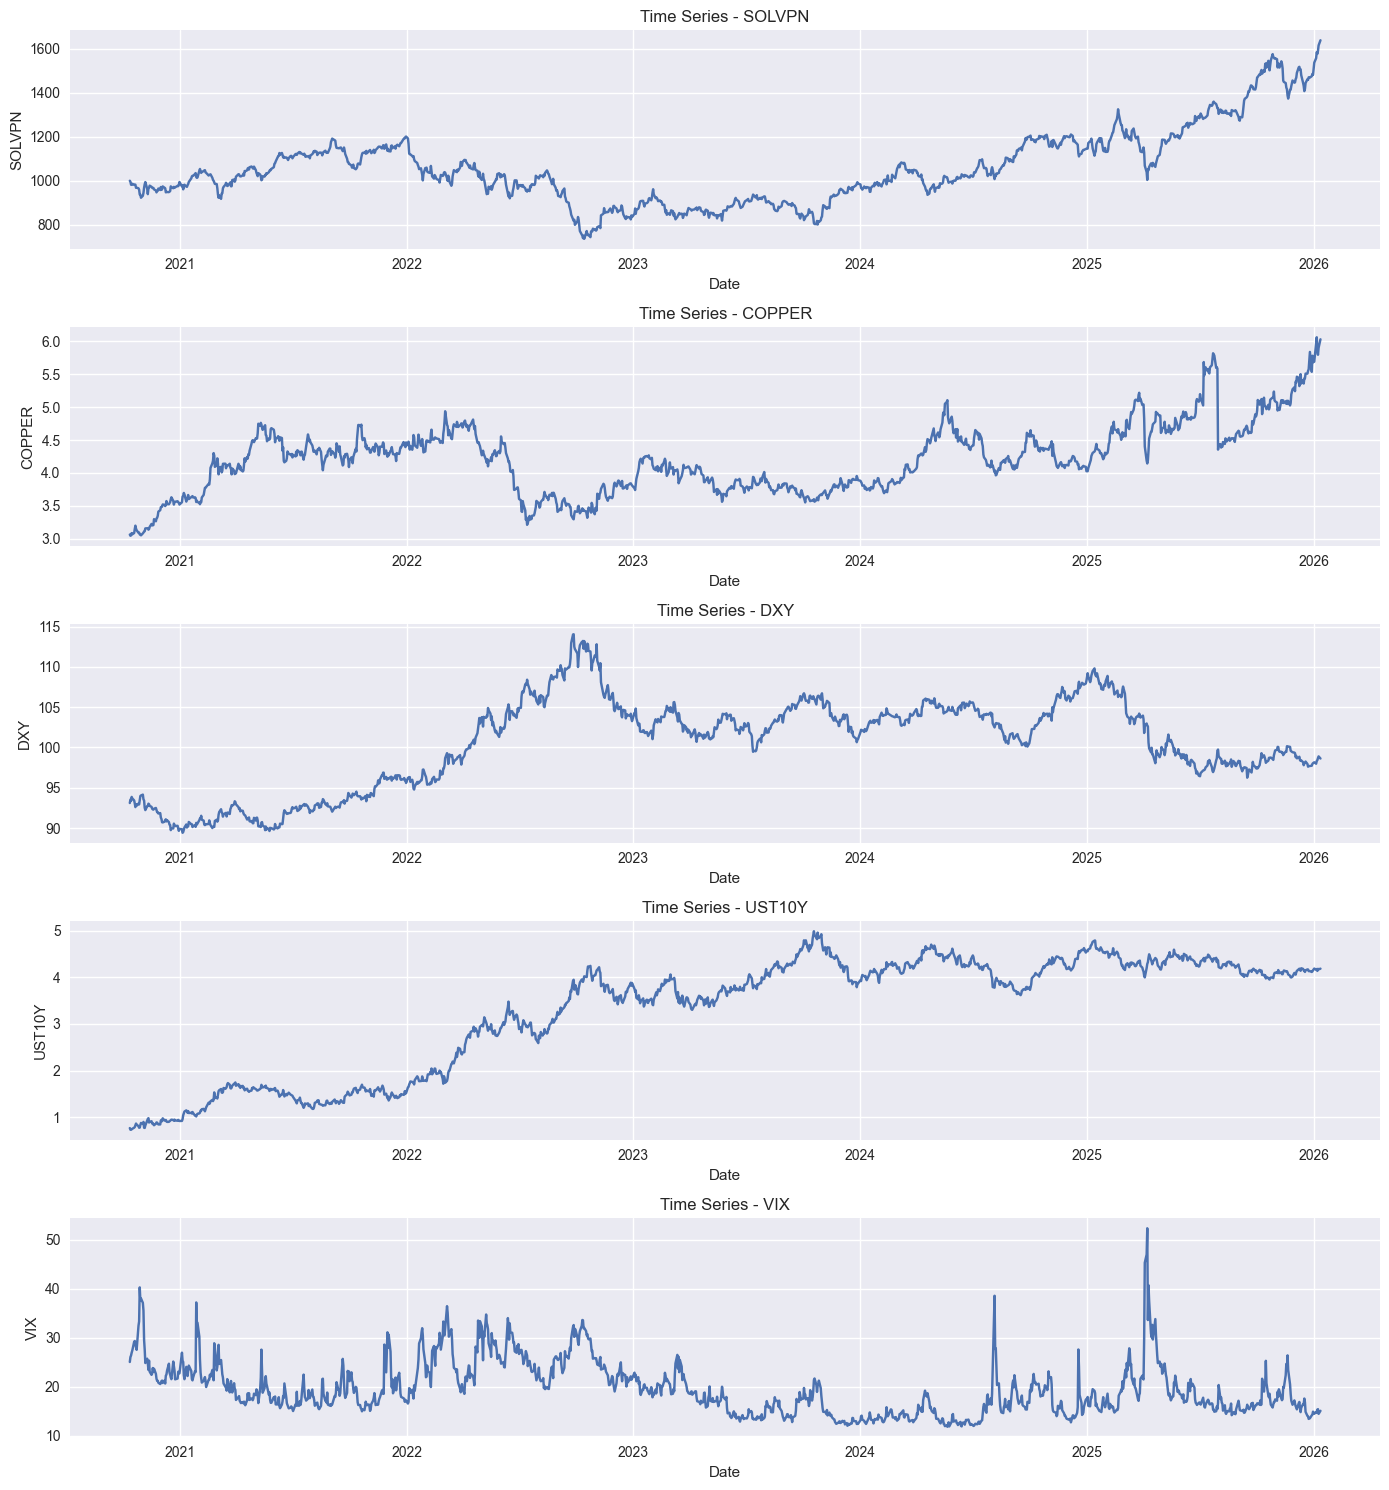

In [1]:
# ============================================================
# Data Visualization for Spillover Dataset
# - Calendar-like availability heatmap
# - Distribution plots
# - Time series plots
# Path: ./merged_spillover_data.csv
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

# ----------------------------
# 1) Load Data
# ----------------------------
DATA_PATH = "./merged_spillover_data.csv"
df = pd.read_csv(DATA_PATH)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print("Data shape:", df.shape)
print("Date range:", df["Date"].min(), "~", df["Date"].max())

# Numeric columns only
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()

# ============================================================
# 2) Calendar-like Availability Plot
# ============================================================

# Create full daily range
full_range = pd.date_range(df["Date"].min(), df["Date"].max(), freq="D")
calendar_df = pd.DataFrame({"Date": full_range})
calendar_df["has_data"] = calendar_df["Date"].isin(df["Date"]).astype(int)

calendar_df["Year"] = calendar_df["Date"].dt.year
calendar_df["Month"] = calendar_df["Date"].dt.month
calendar_df["Day"] = calendar_df["Date"].dt.day

# Pivot for heatmap (Year x Day-of-Year)
calendar_df["DayOfYear"] = calendar_df["Date"].dt.dayofyear

pivot = calendar_df.pivot_table(
    index="Year",
    columns="DayOfYear",
    values="has_data",
    fill_value=0
)

plt.figure(figsize=(18, 6))
sns.heatmap(pivot, cmap="Greens", cbar=False)
plt.title("Data Availability Calendar (1=Data, 0=Missing)")
plt.xlabel("Day of Year")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

# ============================================================
# 3) Distribution Plots
# ============================================================

n_cols = 2
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# ============================================================
# 4) Time Series Plot
# ============================================================

fig, axes = plt.subplots(len(num_cols), 1, figsize=(14, 3 * len(num_cols)))

if len(num_cols) == 1:
    axes = [axes]

for i, col in enumerate(num_cols):
    axes[i].plot(df["Date"], df[col])
    axes[i].set_title(f"Time Series - {col}")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()


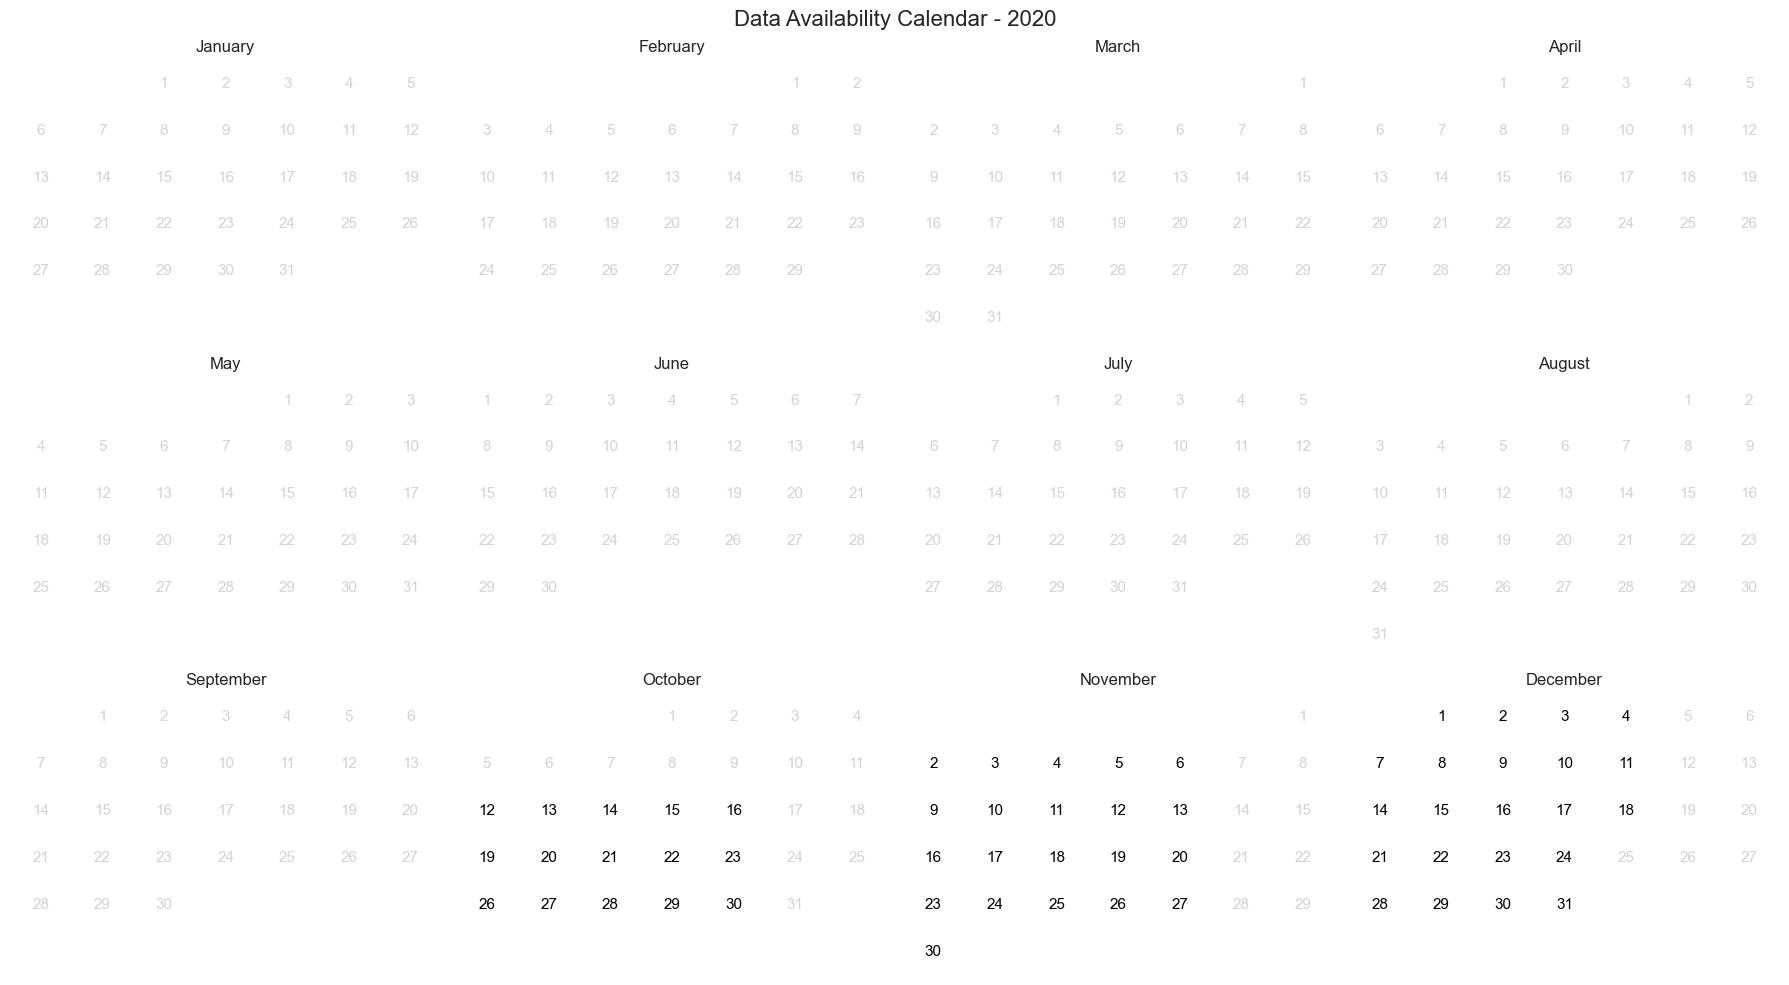

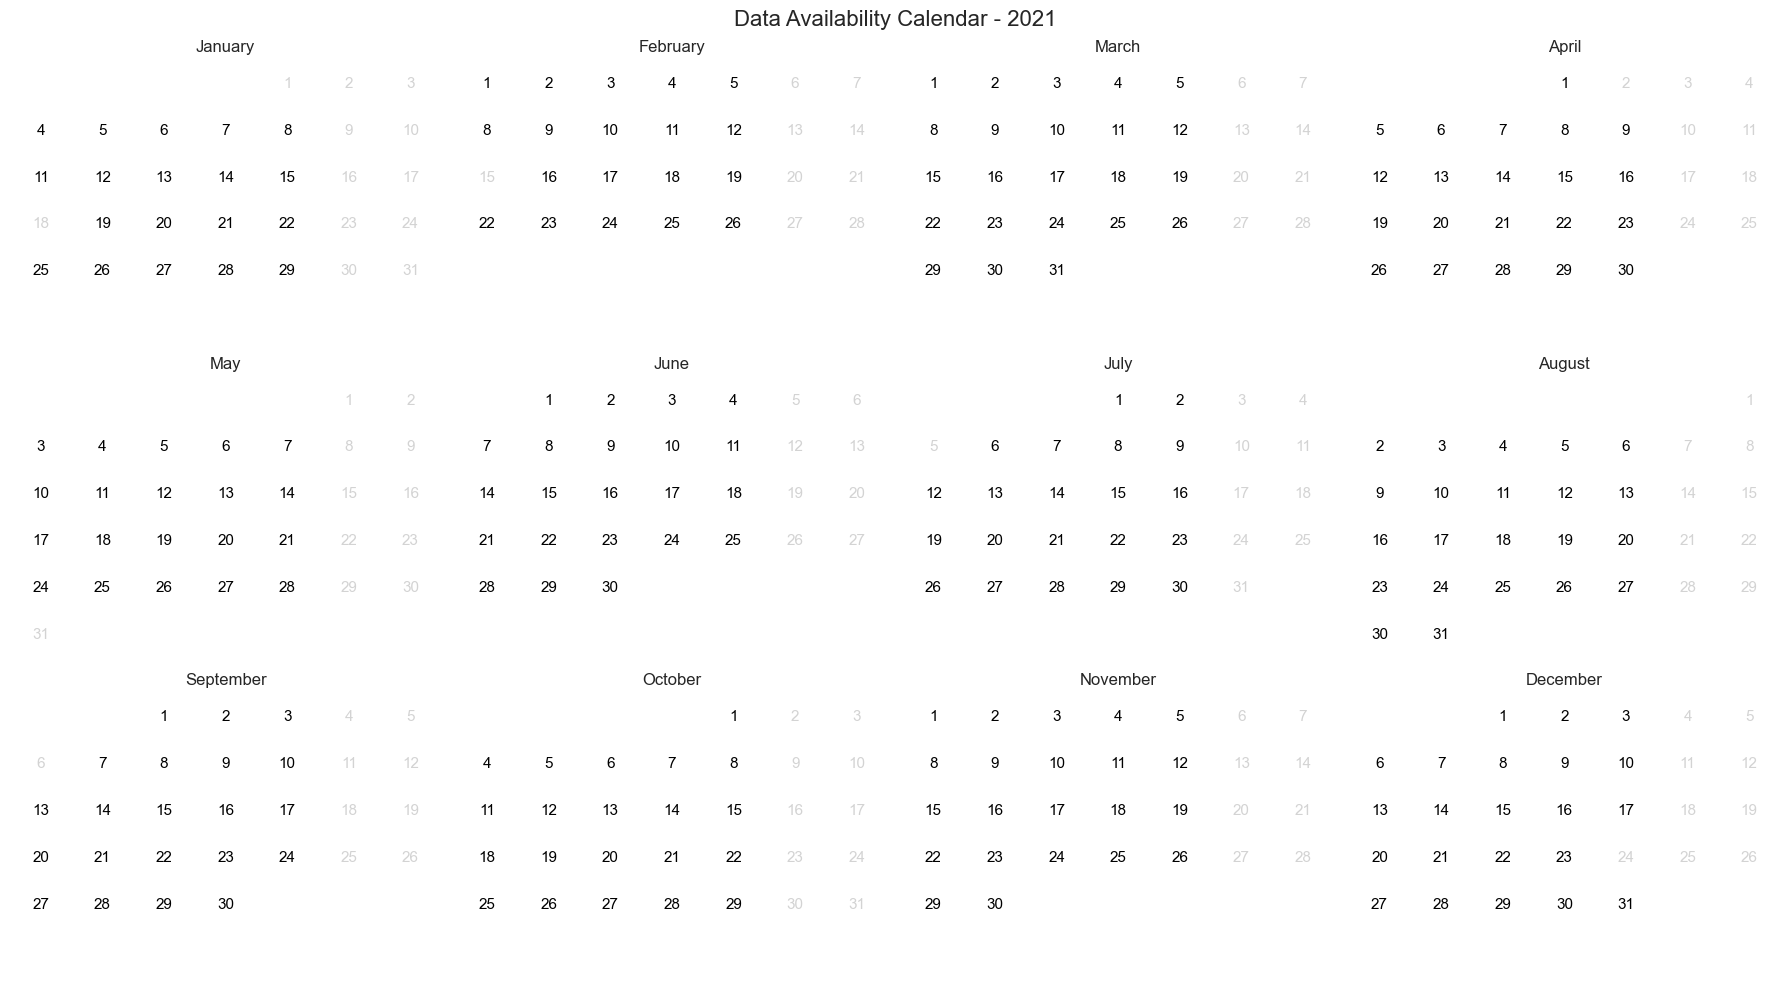

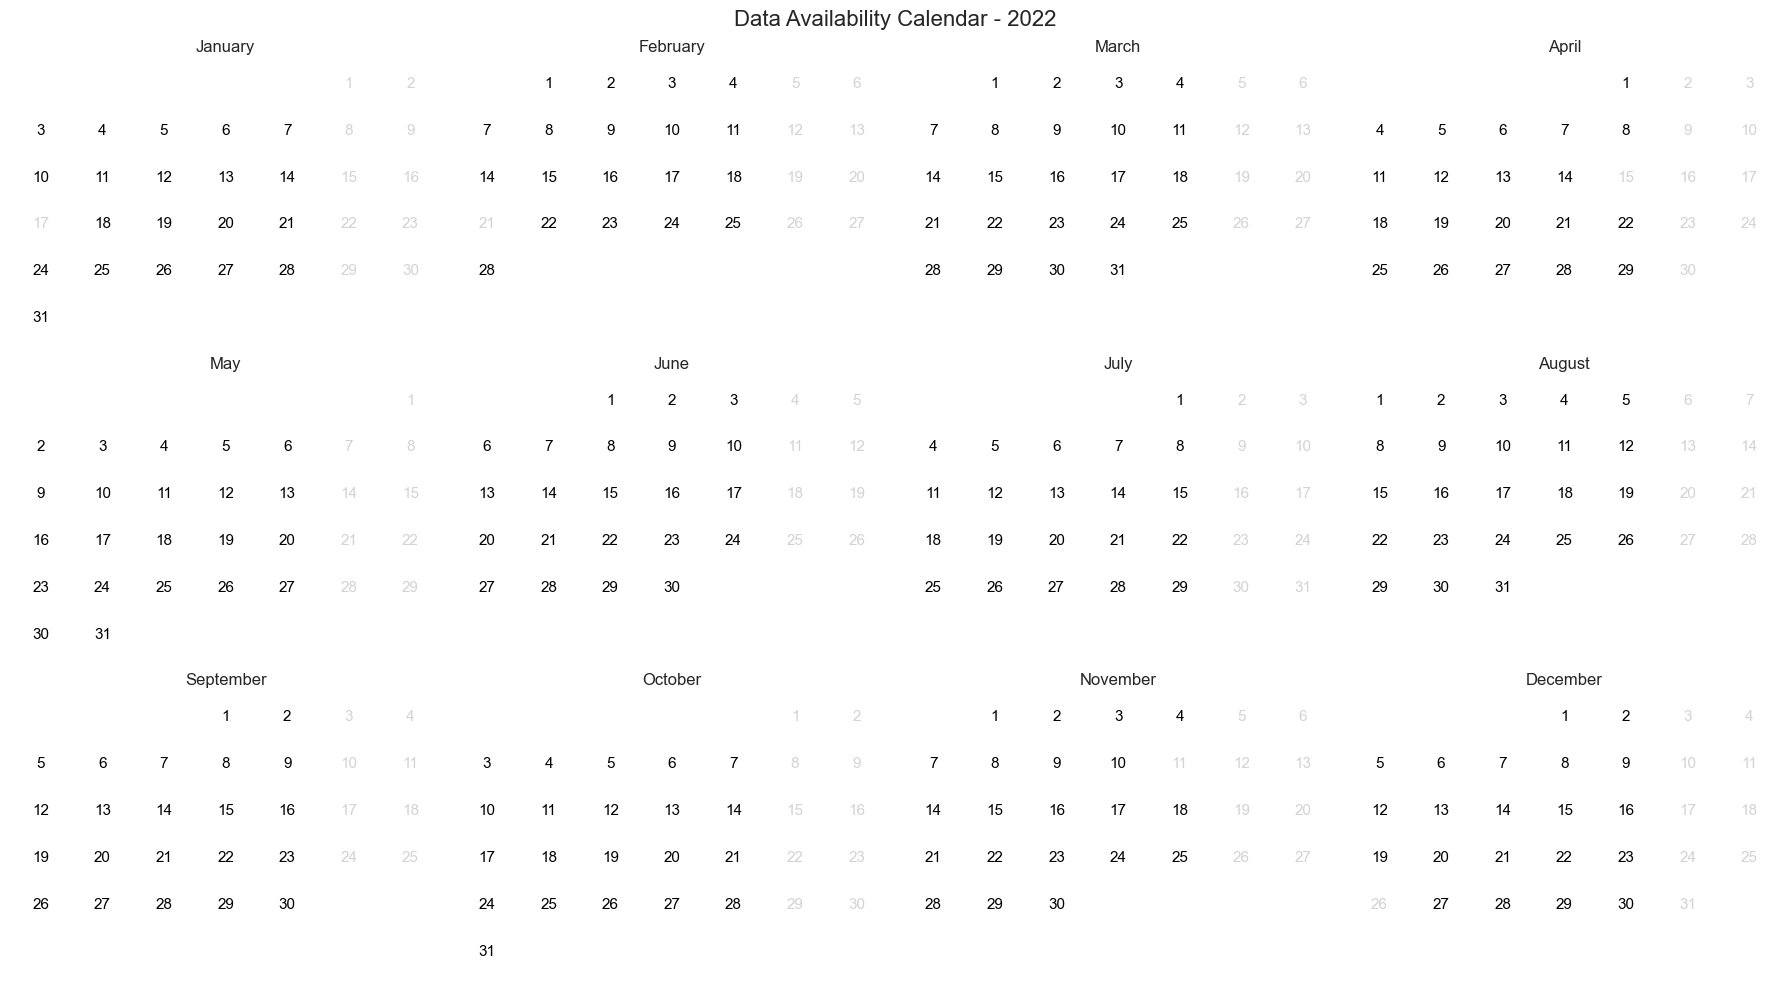

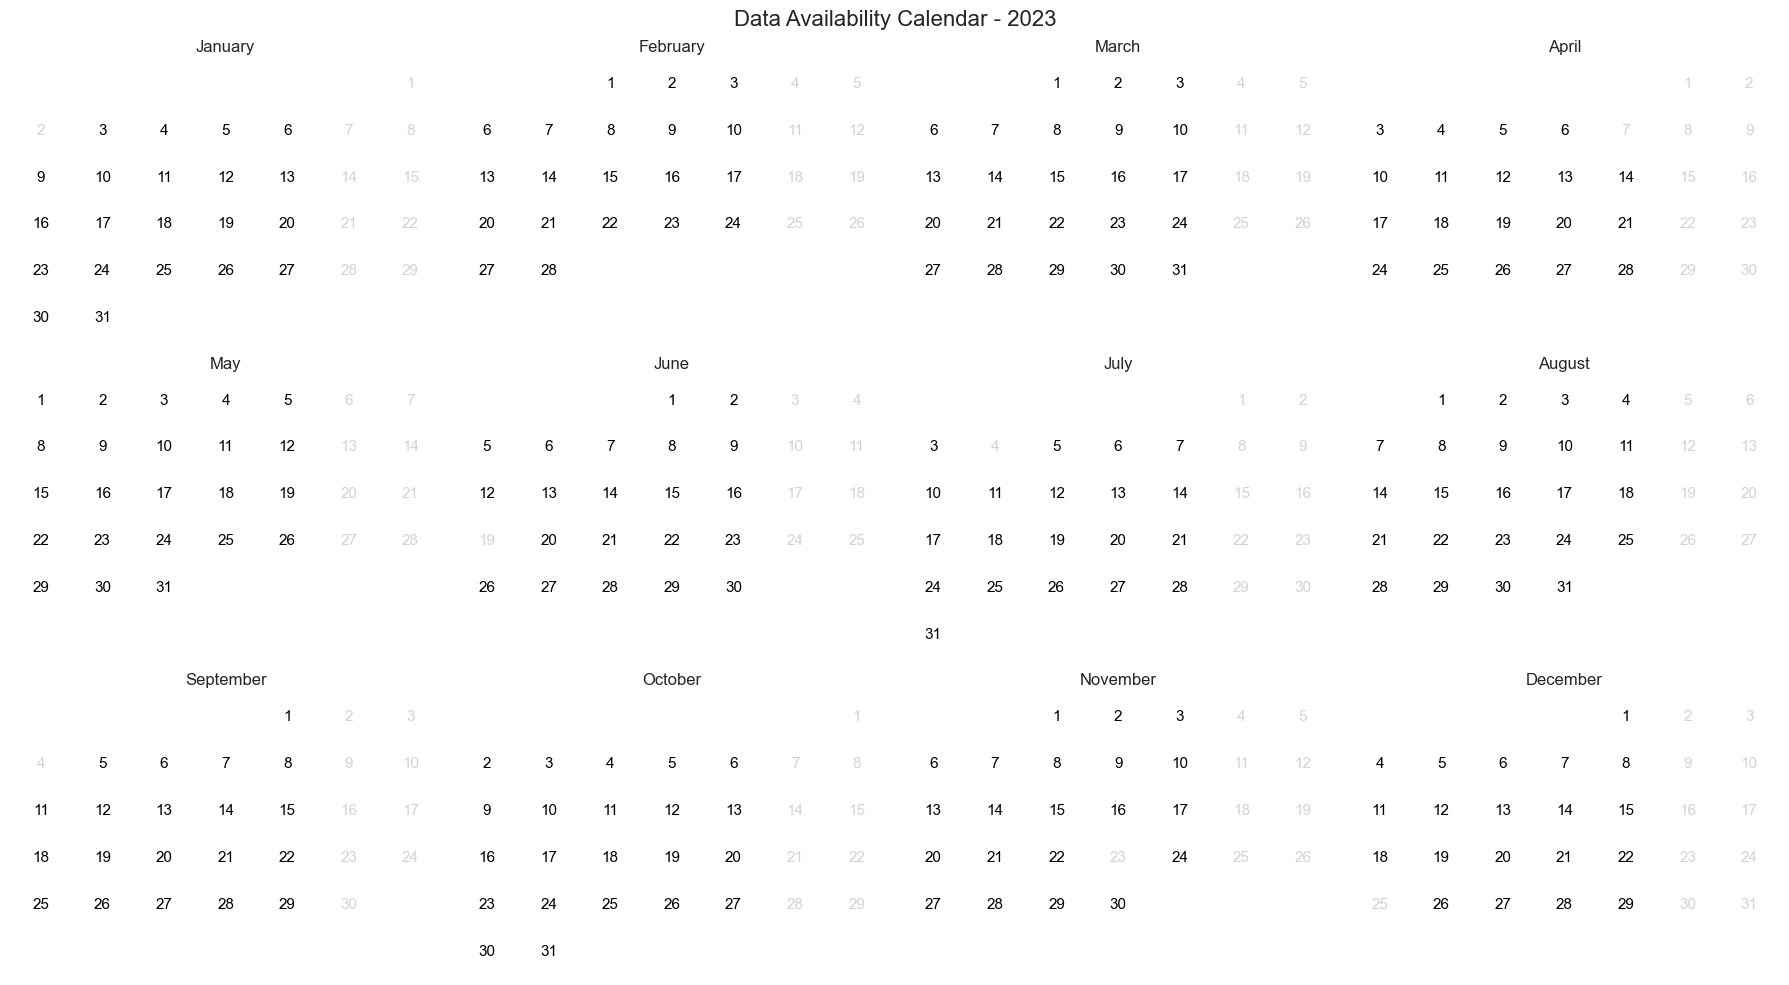

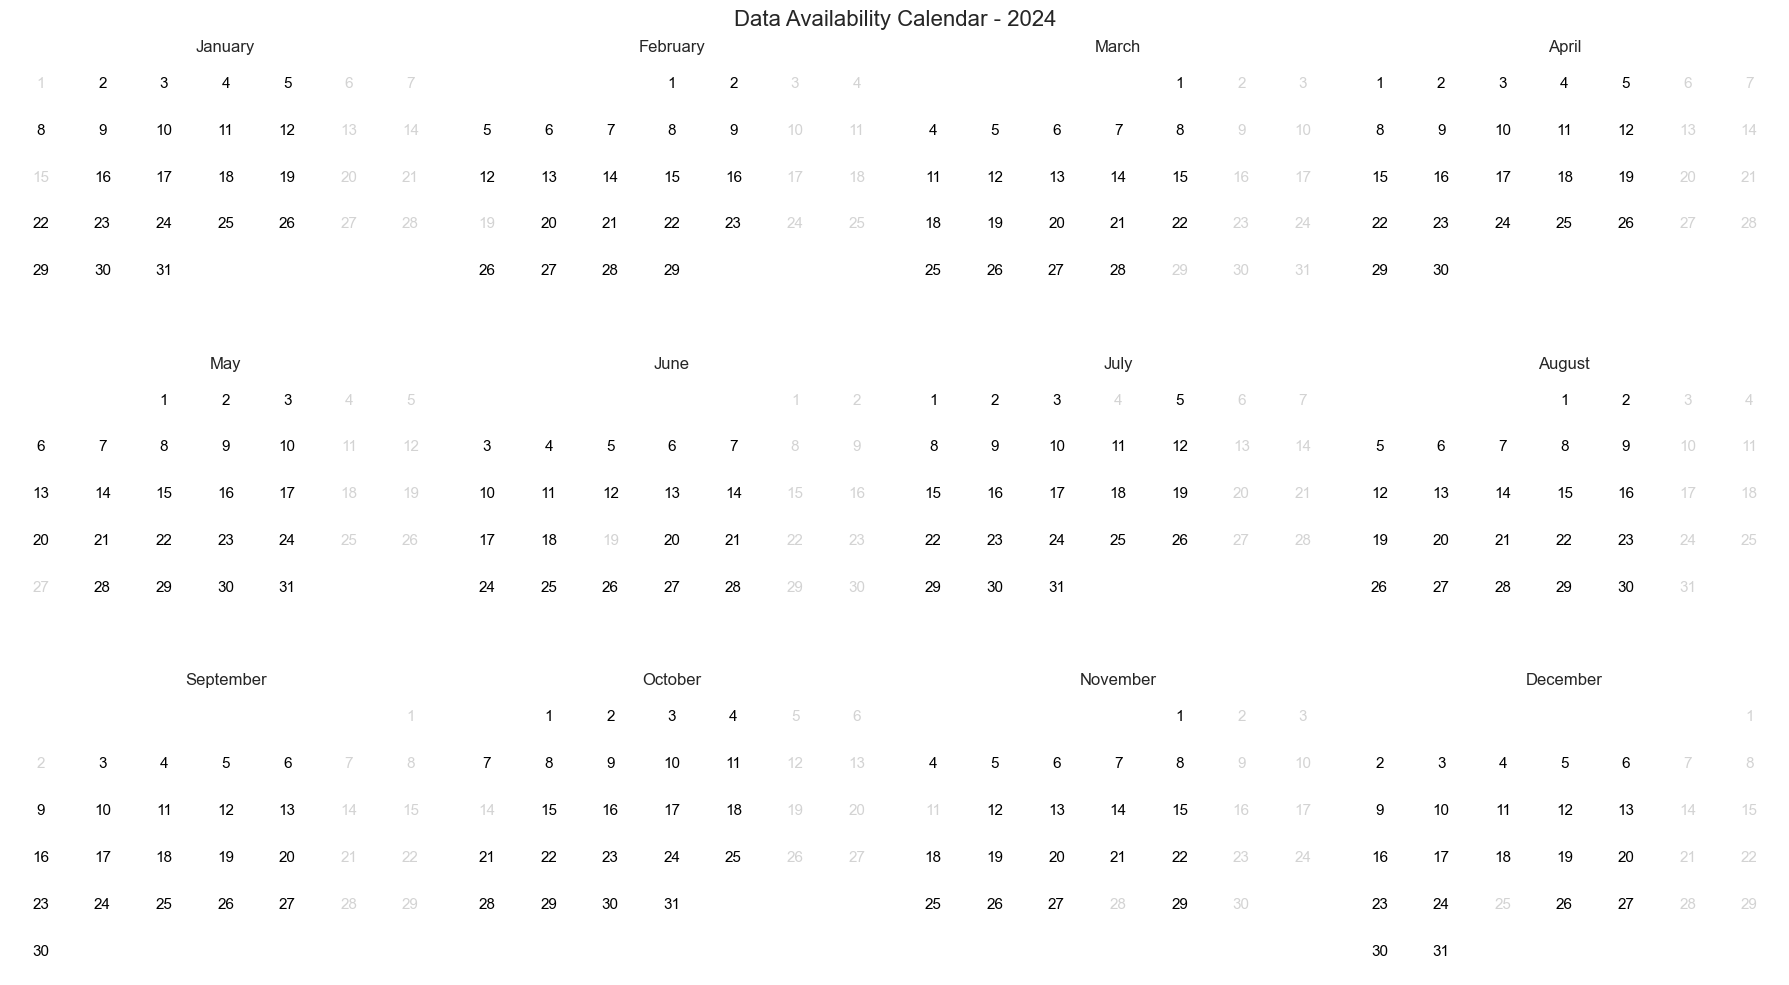

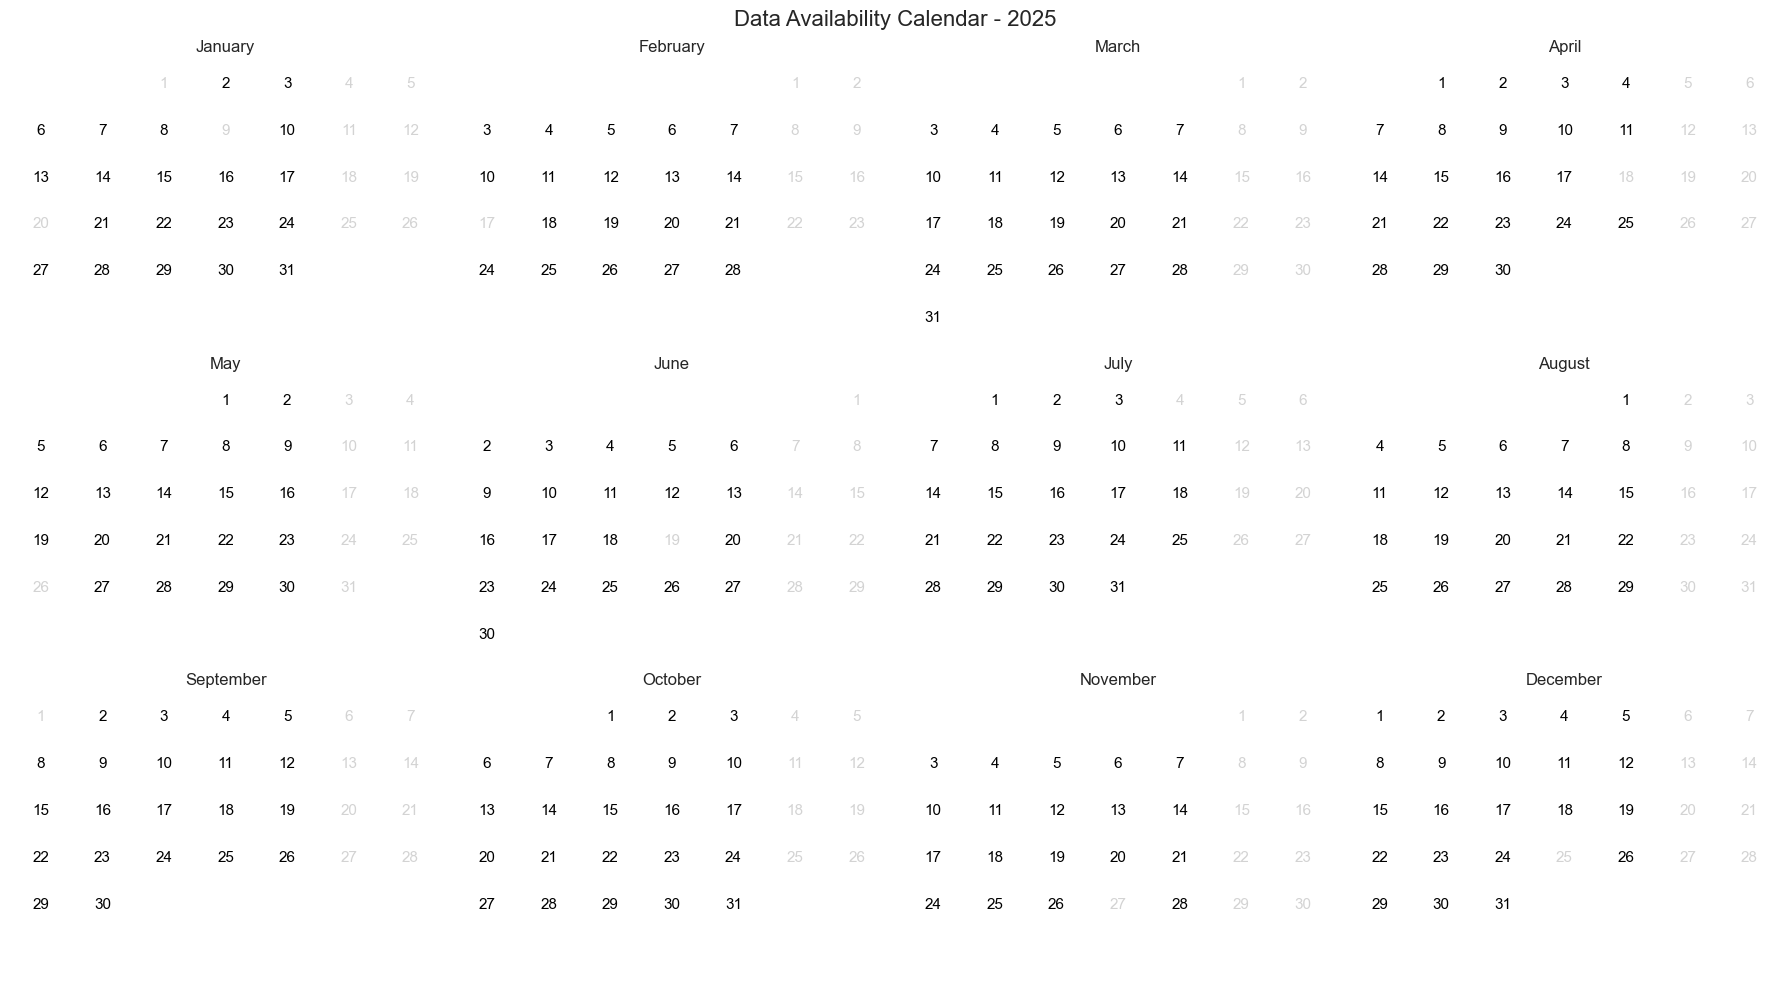

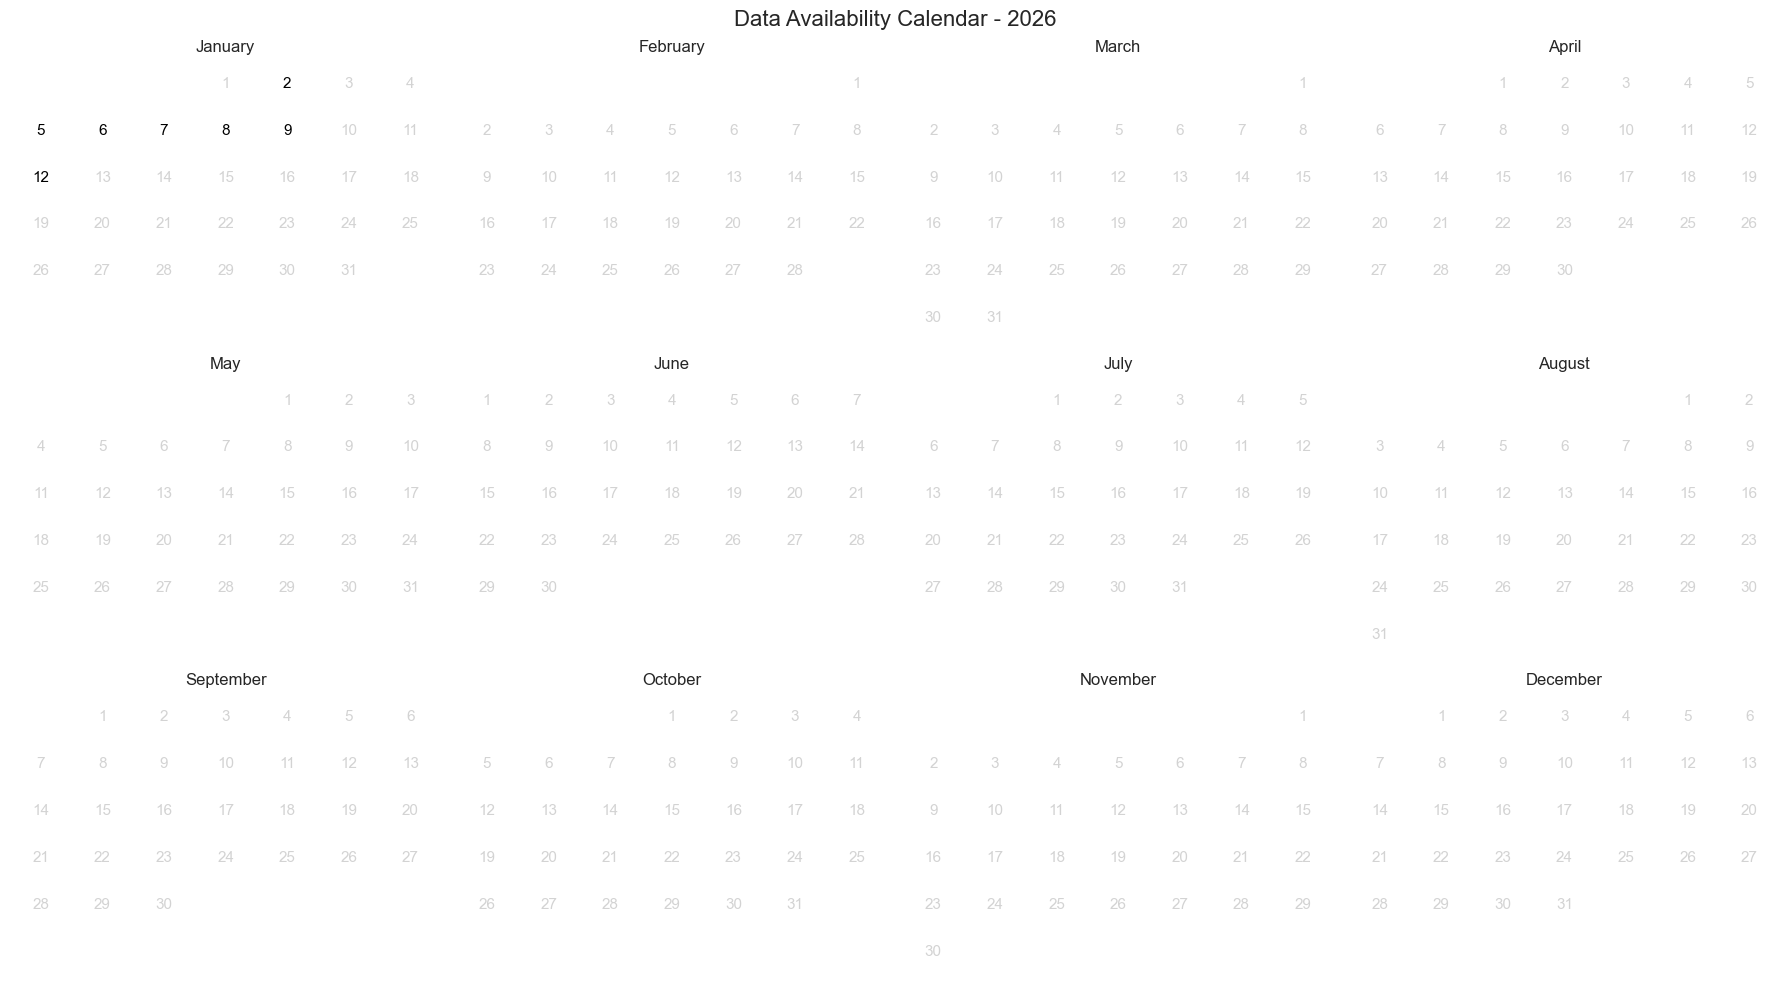

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# ----------------------------
# Load Data
# ----------------------------
df = pd.read_csv("./merged_spillover_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

start_date = df["Date"].min()
end_date = df["Date"].max()

full_range = pd.date_range(start_date, end_date, freq="D")
has_data = set(df["Date"])

years = sorted(pd.Series(full_range).dt.year.unique())

for year in years:
    fig, axes = plt.subplots(3, 4, figsize=(18, 10))
    axes = axes.flatten()

    for month in range(1, 13):
        ax = axes[month - 1]
        ax.set_title(calendar.month_name[month], fontsize=12)

        cal = calendar.monthcalendar(year, month)

        ax.set_xlim(0, 7)
        ax.set_ylim(0, 6)
        ax.invert_yaxis()

        # 축/테두리/격자 완전 제거
        ax.axis("off")

        for week_idx, week in enumerate(cal):
            for day_idx, day in enumerate(week):
                if day == 0:
                    continue

                date = pd.Timestamp(year=year, month=month, day=day)

                if date in has_data:
                    color = "black"  # 데이터 있음
                else:
                    color = "lightgray"  # 데이터 없음

                ax.text(
                    day_idx + 0.5,
                    week_idx + 0.5,
                    str(day),
                    ha="center",
                    va="center",
                    fontsize=11,
                    color=color
                )

    plt.suptitle(f"Data Availability Calendar - {year}", fontsize=16)
    plt.tight_layout()
    plt.show()


In [5]:
import os
import re
import pandas as pd
import numpy as np

FILES = {
    "SOLVPN": "./SOLVPN_index.csv",
    "COPPER": "./copper_futures.csv",
    "DXY": "./dollar_index.csv",
    "UST10Y": "./us_10y_bond_yield.csv",
    "VIX": "./cboe_vix_index.csv"
}

PREFERRED_VALUE_COLS = ["adj close", "adjusted close", "close", "price", "last", "value", "index", "settle"]

def _find_date_col(cols):
    cands = [c for c in cols if re.search(r"(date|time|timestamp)", c, re.IGNORECASE)]
    return cands[0] if cands else cols[0]

def _to_numeric(s: pd.Series) -> pd.Series:
    if s.dtype == "O":
        s = (s.astype(str)
               .str.strip()
               .str.replace(",", "", regex=False)
               .str.replace("%", "", regex=False))
    return pd.to_numeric(s, errors="coerce")

def load_series(path, name):
    df = pd.read_csv(path)
    date_col = _find_date_col(df.columns.tolist())
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col)

    # 선호 컬럼명 우선
    lower_map = {c.lower(): c for c in df.columns}
    chosen = None
    for key in PREFERRED_VALUE_COLS:
        if key in lower_map and lower_map[key] != date_col:
            chosen = lower_map[key]; break
        for lc, orig in lower_map.items():
            if key in lc and orig != date_col:
                chosen = orig; break
        if chosen is not None:
            break

    # 없으면 numeric 변환 성공률로 선택
    if chosen is None:
        best_col, best_ratio = None, -1.0
        for c in [c for c in df.columns if c != date_col]:
            s_num = _to_numeric(df[c])
            ratio = s_num.notna().mean()
            if ratio > best_ratio:
                best_ratio = ratio
                best_col = c
        if best_col is None or best_ratio <= 0.05:
            raise ValueError(f"[{name}] numeric-like column not found. cols={df.columns.tolist()}")
        chosen = best_col

    out = pd.DataFrame({
        "Date": df[date_col],
        name: _to_numeric(df[chosen])
    }).dropna(subset=[name])

    out = out.sort_values("Date").drop_duplicates("Date", keep="last").reset_index(drop=True)
    print(f"[{name}] date_col='{date_col}', value_col='{chosen}', rows={len(out)}")
    return out

# 1) Load all
series_list = []
for name, path in FILES.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}  (현재 경로 ./ 에 두셨는지 확인)")
    series_list.append(load_series(path, name))

# 2) OUTER merge (원인 추적용)
outer = series_list[0]
for s in series_list[1:]:
    outer = outer.merge(s, on="Date", how="outer")

outer = outer.sort_values("Date").reset_index(drop=True)

# 3) 어떤 날짜에 어떤 컬럼이 빠졌는지: weekday(월~금)만
outer["weekday"] = outer["Date"].dt.weekday  # 0=Mon ... 6=Sun
cols = [c for c in outer.columns if c not in ["Date", "weekday"]]

# 최소 1개라도 결측이면 "결측 날짜"로 표시
missing_mask = outer[cols].isna().any(axis=1)
missing_weekday = outer[missing_mask & (outer["weekday"] < 5)].copy()

# 4) 원인 컬럼 리스트업
def missing_cols(row):
    return [c for c in cols if pd.isna(row[c])]

missing_weekday["missing_cols"] = missing_weekday.apply(missing_cols, axis=1)

print("\n=== Missing weekdays (Mon-Fri) with causes ===")
if len(missing_weekday) == 0:
    print("No missing weekday rows in OUTER-merged table.")
else:
    for _, r in missing_weekday.iterrows():
        d = r["Date"].date()
        causes = ", ".join(r["missing_cols"])
        print(f"{d} : {causes}")

# 원하면 CSV로 저장
missing_weekday[["Date", "missing_cols"]].to_csv("./missing_weekday_causes.csv", index=False)
print("\nSaved: ./missing_weekday_causes.csv")


[SOLVPN] date_col='Date', value_col='Close', rows=1344
[COPPER] date_col='Date', value_col='Close', rows=2618
[DXY] date_col='Date', value_col='Close', rows=2595
[UST10Y] date_col='Date', value_col='Close', rows=2619
[VIX] date_col='Date', value_col='Close', rows=1558

=== Missing weekdays (Mon-Fri) with causes ===
2016-01-04 : SOLVPN, VIX
2016-01-05 : SOLVPN, VIX
2016-01-06 : SOLVPN, VIX
2016-01-07 : SOLVPN, VIX
2016-01-08 : SOLVPN, VIX
2016-01-11 : SOLVPN, VIX
2016-01-12 : SOLVPN, VIX
2016-01-13 : SOLVPN, VIX
2016-01-14 : SOLVPN, VIX
2016-01-15 : SOLVPN, VIX
2016-01-18 : SOLVPN, COPPER, VIX
2016-01-19 : SOLVPN, VIX
2016-01-20 : SOLVPN, VIX
2016-01-21 : SOLVPN, VIX
2016-01-22 : SOLVPN, VIX
2016-01-25 : SOLVPN, VIX
2016-01-26 : SOLVPN, VIX
2016-01-27 : SOLVPN, VIX
2016-01-28 : SOLVPN, VIX
2016-01-29 : SOLVPN, VIX
2016-02-01 : SOLVPN, VIX
2016-02-02 : SOLVPN, VIX
2016-02-03 : SOLVPN, VIX
2016-02-04 : SOLVPN, VIX
2016-02-05 : SOLVPN, VIX
2016-02-08 : SOLVPN, VIX
2016-02-09 : SOLVPN, VIX
